In [1]:
import warnings
import pathlib
from datetime import datetime, timedelta
import multiprocessing

import numpy as np
import pandas as pd
import xarray as xr
import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colorbar import ColorbarBase
from matplotlib import patches
import cartopy.crs as ccrs

import intake
import healpy

In [6]:
def plot_a_timestep(t: str | np.datetime64):
    if isinstance(t, str):
        t = np.datetime64(t, "ns")

    date = datetime.fromisoformat(str(t))
    
    # Load tracks
    tracks_path = pathlib.Path("./tracks.nc")
    tracks = xr.open_dataset(tracks_path).to_dataframe()
    tracks_t = tracks[tracks.time==date]

    # Load mask file
    data_path = pathlib.Path(f"/scratch/b/b382728/tobac_precip_features/")
    label_ds = xr.open_dataset(
        list(
            (data_path / f'{date.year}' / f'{date.month:02d}' / f'{date.day:02d}').glob(
                f'tobac_{date.strftime("%Y%m%d-%H")}*_feature_mask_file.nc'
            )
        )[0]
    ).all_feature_labels.sel(time=t)
    

    # Load OLR and precip
    cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
    dataset = cat.ICON.ngc4008(time="PT15M", zoom=9).to_dask().sel(time=t)

    pix = xr.DataArray(
        healpy.ang2pix(dataset.crs.healpix_nside, *np.meshgrid(label_ds.lon, label_ds.lat), nest=True, lonlat=True),
        coords=(label_ds.lat, label_ds.lon),
    )
    
    olr = dataset.rlut.isel(cell=pix)
    pr = dataset.pr.isel(cell=pix) * 3.6e3

    dataset.close()

    # Create colormaps
    alpha_cmap = np.ones([256,4])
    alpha_cmap[:,-1] = np.linspace(0,1,256)
    alpha_cmap = ListedColormap(alpha_cmap)

    viridis_alpha = plt.cm.viridis(np.linspace(0,1,256))
    viridis_alpha[...,-1] = np.linspace(0,1,256)**0.125
    viridis_alpha = ListedColormap(viridis_alpha)
    
    cbar_cmap = np.ones([256,4])
    cbar_cmap[:,0] = np.linspace(0,1,256)
    cbar_cmap[:,1] = np.linspace(0,1,256)
    cbar_cmap[:,2] = np.linspace(0.25,1,256)
    cbar_cmap = ListedColormap(cbar_cmap)

    # Plot
    fig, ax = plt.subplots(subplot_kw = dict(projection=ccrs.Robinson()), figsize=(9.6,4.4))

    ax.imshow(
        plt.imread("/home/b/b382728/data/world.200407.3x5400x2700.jpg"),
        extent=[-180,180,-90,90], transform=ccrs.PlateCarree()
    )
    
    ax.imshow(
        -olr, cmap=alpha_cmap, vmin=-250, vmax=-100, 
        extent=[0,360,-90,90], transform=ccrs.PlateCarree()
    )
    
    ax.imshow(
        pr, cmap=viridis_alpha, vmin=0.5, vmax=5, 
        extent=[0,360,-90,90], transform=ccrs.PlateCarree()
    )
    
    ax.contour(
        *np.meshgrid(label_ds.lon, label_ds.lat), np.isin(label_ds, tracks_t.label), 
        [0.5], colors=["C03"], linewidths=[0.5], 
        transform=ccrs.PlateCarree()
    )

    ax.set_extent([-180,180,-80,80], crs=ccrs.PlateCarree())

    ax.set_title(f'                    ICON/NextGEMS cycle 4:', loc="left")
    ax.set_title(f'{date.isoformat()}                    ', loc="right")
    
    ax_position = ax.get_position().bounds
    cax = fig.add_axes([ax_position[0] + ax_position[2]*0.1, 0, ax_position[2]*0.35, 0.025])
    cbar = ColorbarBase(cax, cmap=cbar_cmap, orientation = 'horizontal')
    cbar.set_ticks(np.linspace(0,1,4), labels=np.linspace(250,100,4))
    cbar.set_label(r"OLR [$\mathrm{W\,m^{-2}}$]")
    
    cax = fig.add_axes([ax_position[0] + ax_position[2]*0.55, 0, ax_position[2]*0.35, 0.025])
    cbar = ColorbarBase(cax, cmap=viridis_alpha, orientation = 'horizontal')
    cbar.set_ticks(np.linspace(0,1,10), labels=np.linspace(0.5,5,10))
    cbar.set_label(r"Precip [$\mathrm{mm\,hour^{-1}}$]")
    
    # And save
    timestr = str(t.astype("datetime64[s]")).replace("-", "").replace(":", "")
    fig.savefig(f'./tracks_frames/tracks_anim_frame_{timestr}.png', bbox_inches="tight", pad_inches=0.2)
    
    return fig


/home/b/b382728/miniconda3/envs/tobac/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


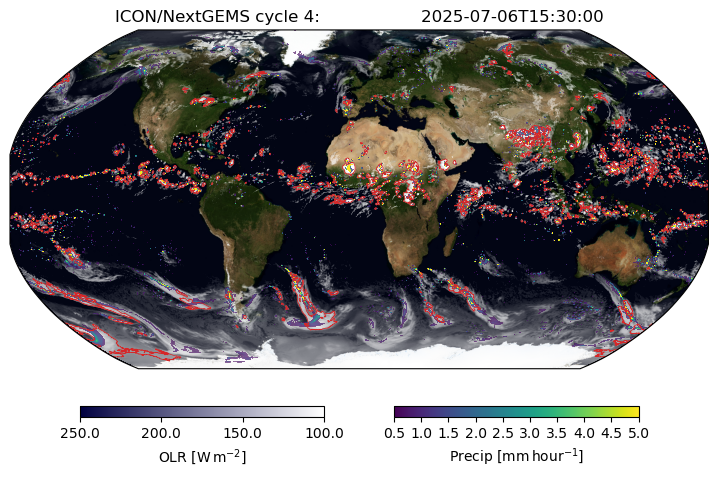

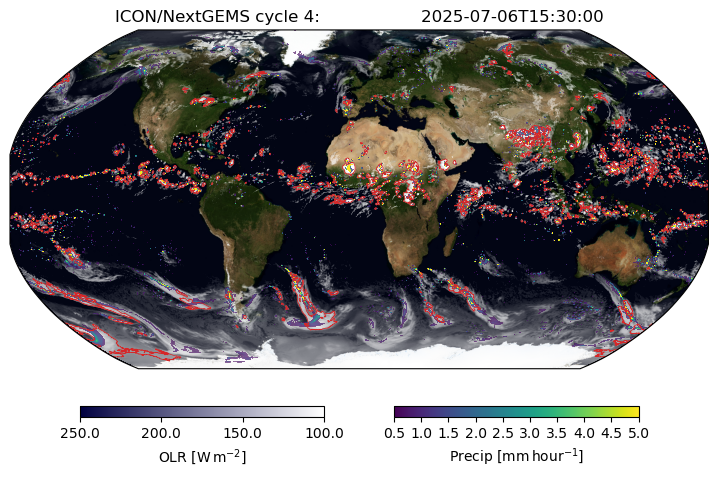

In [7]:
plot_a_timestep("2025-07-06T15:30:00")

In [12]:
# Now for subplots
def plot_a_timestep(t: str | np.datetime64):
    if isinstance(t, str):
        t = np.datetime64(t, "ns")

    date = datetime.fromisoformat(str(t))
    
    # Load tracks
    tracks_path = pathlib.Path("./tracks.nc")
    tracks = xr.open_dataset(tracks_path).to_dataframe()
    tracks_t = tracks[tracks.time==date]

    # Load mask file
    data_path = pathlib.Path(f"/scratch/b/b382728/tobac_precip_features/")
    label_ds = xr.open_dataset(
        list(
            (data_path / f'{date.year}' / f'{date.month:02d}' / f'{date.day:02d}').glob(
                f'tobac_{date.strftime("%Y%m%d-%H")}*_feature_mask_file.nc'
            )
        )[0]
    ).all_feature_labels.sel(time=t)
    

    # Load OLR and precip
    cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
    dataset = cat.ICON.ngc4008(time="PT15M", zoom=9).to_dask().sel(time=t)

    pix = xr.DataArray(
        healpy.ang2pix(dataset.crs.healpix_nside, *np.meshgrid(label_ds.lon, label_ds.lat), nest=True, lonlat=True),
        coords=(label_ds.lat, label_ds.lon),
    )
    
    olr = dataset.rlut.isel(cell=pix)
    pr = dataset.pr.isel(cell=pix) * 3.6e3

    dataset.close()

    # Create colormaps
    alpha_cmap = np.ones([256,4])
    alpha_cmap[:,-1] = np.linspace(0,1,256)
    alpha_cmap = ListedColormap(alpha_cmap)

    viridis_alpha = plt.cm.viridis(np.linspace(0,1,256))
    viridis_alpha[...,-1] = np.linspace(0,1,256)**0.125
    viridis_alpha = ListedColormap(viridis_alpha)
    
    cbar_cmap = np.ones([256,4])
    cbar_cmap[:,0] = np.linspace(0,1,256)
    cbar_cmap[:,1] = np.linspace(0,1,256)
    cbar_cmap[:,2] = np.linspace(0.25,1,256)
    cbar_cmap = ListedColormap(cbar_cmap)

    # Plot
    fig, axes = plt.subplots(1,3,subplot_kw = dict(projection=ccrs.PlateCarree()), figsize=(9.6,2.4), dpi=150)

    axes[0].set_extent([-105,-60,-10,20], crs=ccrs.PlateCarree())
    axes[1].set_extent([-22.5,22.5,-15,15], crs=ccrs.PlateCarree())
    axes[2].set_extent([95,140,-20,10], crs=ccrs.PlateCarree())

    axes[0].imshow(
        plt.imread("/home/b/b382728/data/world.200407.3x5400x2700.jpg"),
        extent=[-180,180,-90,90], transform=ccrs.PlateCarree()
    )
    
    axes[0].imshow(
        -olr, cmap=alpha_cmap, vmin=-250, vmax=-100, 
        extent=[0,360,-90,90], transform=ccrs.PlateCarree()
    )
    
    axes[0].imshow(
        pr, cmap=viridis_alpha, vmin=0.5, vmax=5, 
        extent=[0,360,-90,90], transform=ccrs.PlateCarree()
    )
    
    axes[0].contour(
        *np.meshgrid(label_ds.lon, label_ds.lat), np.isin(label_ds, tracks_t.label), 
        [0.5], colors=["C03"], linewidths=[1], 
        transform=ccrs.PlateCarree()
    )

    axes[1].imshow(
        plt.imread("/home/b/b382728/data/world.200407.3x5400x2700.jpg"),
        extent=[-180,180,-90,90], transform=ccrs.PlateCarree()
    )
    
    axes[1].imshow(
        -olr, cmap=alpha_cmap, vmin=-250, vmax=-100, 
        extent=[0,360,-90,90], transform=ccrs.PlateCarree()
    )
    
    axes[1].imshow(
        pr, cmap=viridis_alpha, vmin=0.5, vmax=5, 
        extent=[0,360,-90,90], transform=ccrs.PlateCarree()
    )
    
    axes[1].contour(
        *np.meshgrid(label_ds.lon, label_ds.lat), np.isin(label_ds, tracks_t.label), 
        [0.5], colors=["C03"], linewidths=[1], 
        transform=ccrs.PlateCarree()
    )

    axes[2].imshow(
        plt.imread("/home/b/b382728/data/world.200407.3x5400x2700.jpg"),
        extent=[-180,180,-90,90], transform=ccrs.PlateCarree()
    )
    
    axes[2].imshow(
        -olr, cmap=alpha_cmap, vmin=-250, vmax=-100, 
        extent=[0,360,-90,90], transform=ccrs.PlateCarree()
    )
    
    axes[2].imshow(
        pr, cmap=viridis_alpha, vmin=0.5, vmax=5, 
        extent=[0,360,-90,90], transform=ccrs.PlateCarree()
    )
    
    axes[2].contour(
        *np.meshgrid(label_ds.lon, label_ds.lat), np.isin(label_ds, tracks_t.label), 
        [0.5], colors=["C03"], linewidths=[1], 
        transform=ccrs.PlateCarree()
    )

    axes[0].set_title(f'  ICON/NextGEMS cycle 4:', loc="left")
    axes[2].set_title(f'{date.isoformat()}  ', loc="right")
    
    ax0_position = axes[0].get_position().bounds
    ax2_position = axes[2].get_position().bounds
    left = ax0_position[0]
    width = ax2_position[0] + ax2_position[2] - left
    
    cax = fig.add_axes([left + width*0.1, 0, width*0.35, 0.05])
    cbar = ColorbarBase(cax, cmap=cbar_cmap, orientation = 'horizontal')
    cbar.set_ticks(np.linspace(0,1,4), labels=np.linspace(250,100,4))
    cbar.set_label(r"OLR [$\mathrm{W\,m^{-2}}$]")
    
    cax = fig.add_axes([left + width*0.55, 0, width*0.35, 0.05])
    cbar = ColorbarBase(cax, cmap=viridis_alpha, orientation = 'horizontal')
    cbar.set_ticks(np.linspace(0,1,10), labels=np.linspace(0.5,5,10))
    cbar.set_label(r"Precip [$\mathrm{mm\,hour^{-1}}$]")
    
    # And save
    timestr = str(t.astype("datetime64[s]")).replace("-", "").replace(":", "")
    fig.savefig(f'./inset_frames/tracks_anim_frame_{timestr}.png', bbox_inches="tight", pad_inches=0.2)
    
    return fig


/home/b/b382728/miniconda3/envs/tobac/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


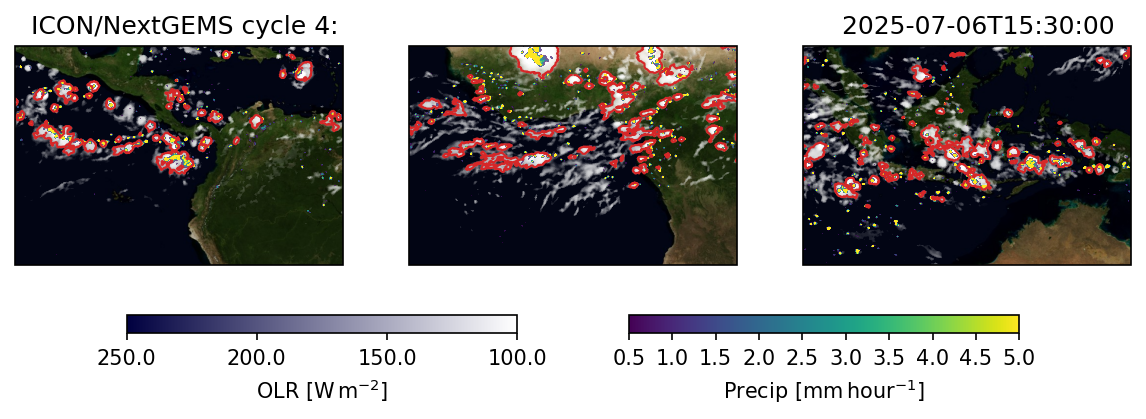

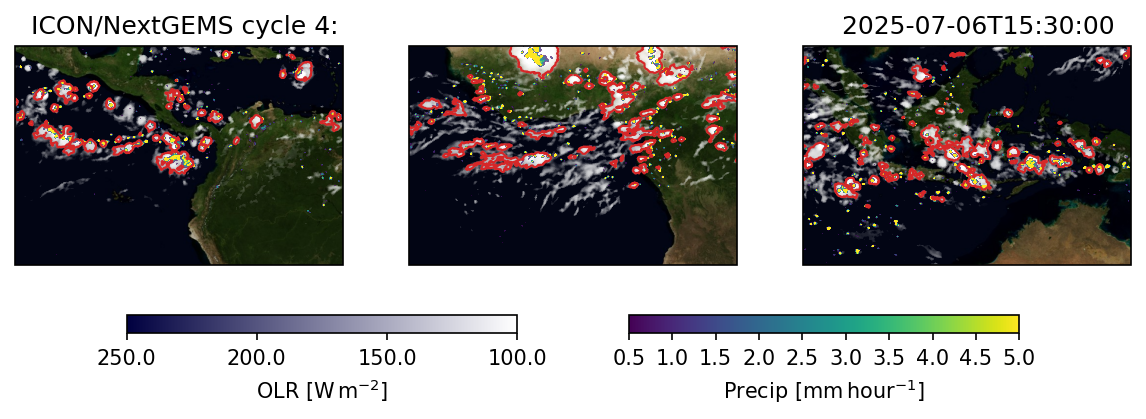

In [13]:
plot_a_timestep("2025-07-06T15:30:00")